In [23]:
import os
import pandas as pd
import sys
import os
import shutil


#### Clean Sample Data Directories

In [24]:

def clean_directory(content):
    # Specify the content directory
    content_directory = content

    # Delete everything inside the content directory
    for filename in os.listdir(content_directory):
        file_path = os.path.join(content_directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

# Execute cleaning
clean_directory('./sample_data/')

In [25]:
import os
import random
from shutil import copyfile
import pandas as pd
from sklearn.model_selection import train_test_split


############################ Functions


def save_csv(data, csv_output_path, file_name):
    data.to_csv(os.path.join(csv_output_path,file_name), index=False)


def create_directory(data, image_folder_path, image_folder_output_path):
    j = 0
    os.makedirs(os.path.join(image_folder_output_path), exist_ok=True)


    for i in data.iterrows():
        os.makedirs(os.path.dirname(
            os.path.join(image_folder_output_path, i[1]['chan_image_path'])),
                    exist_ok=True)

        copyfile(os.path.join(image_folder_path, i[1]['chan_image_path']),
                 os.path.join(image_folder_output_path, i[1]['chan_image_path']))
        j += 1

        if not j % 2500:
            print(f"{j} images copied")

    files = os.listdir(image_folder_output_path)

    print(f"Done: {j} image(s) copied")




def create_df(csv_file_name, target="style", v_ratio=None, t_ratio=None, keep_genre=True, n=None, strategy="drop",
              csv_output_path=None, image_folder_path=None, image_folder_output_path=None ):
    
    #First step create a dataframe from generated csv_file storing all images / artists/genres/styles
    df = pd.read_csv(csv_file_name)

    #Validate validation and test ratios exist as input
    assert (v_ratio and t_ratio) or (
        not v_ratio and not t_ratio), "double check v_ratio and t_ratio"
    
    #Remove images with genres == Nan
    if keep_genre:
        df.dropna(axis=0, subset=['genre'], inplace=True)
        keep_genre = True
    
    # Sampling Strategies
    if n:

        if strategy=='drop':
            class2keep = (df.groupby(by=target)[target].count() >= n).to_dict()
            df = df[df[target].apply(lambda x: class2keep.get(x,False))]
            df = df.groupby(by=target).sample(n=n,
                                              random_state=123,
                                              replace=False)
        if strategy=='max':
            class2sample  = (df.groupby(by=target)[target].count() >= n).to_dict()
            data2sample = df[df[target].apply(lambda x: class2sample.get(x,False))]
            data2keep = df[df[target].apply(lambda x: not class2sample.get(x,False))]

            data2sample = data2sample.groupby(by=target).sample(n=n, random_state=123,
                                                                replace=False)

            df = pd.concat([data2keep,data2sample])

    # Test and Validation split
    if v_ratio and t_ratio:
        df_train, df_val_test = train_test_split(
            df,
            test_size=v_ratio + t_ratio,
            random_state=123,
            stratify=df[target])
        
        df_val, df_test = train_test_split(df_val_test,
                                           test_size=t_ratio /
                                           (v_ratio + t_ratio),
                                           random_state=123,
                                           stratify=df_val_test[target])

        df_train.insert(1, "split", ["train"]*df_train.shape[0])
        df_val.insert(1, "split", ["val"]*df_val.shape[0])
        df_test.insert(1, "split", ["test"]*df_test.shape[0])

        df = pd.concat([df_train, df_val, df_test],ignore_index=True)


    # Save csv
    if csv_output_path:
        csv_name = f"wikiart-target_{target}-class_{df[target].nunique()}-keepgenre_{keep_genre}"
        if n: csv_name = f"{csv_name}-n_{n}_{strategy}"
        csv_name = f"{csv_name}-raw"
        save_csv(df, csv_output_path, f"{csv_name}.csv")

    # Create new directory
    if image_folder_path and image_folder_output_path:
        dir_name = f"wikiart-target_{target}-class_{df[target].nunique()}-keepgenre_{keep_genre}"
        if n: dir_name = f"{dir_name}-n_{n}_{strategy}"
        dir_name = f"{dir_name}-raw"
        create_directory(df, image_folder_path,
                         os.path.join(image_folder_output_path, dir_name))

    return df


######################################################################### Creating Dataframe with Metadata


def get_annotations(csv_folder_path, target):
    return pd.read_csv(os.path.join(csv_folder_path, target + "_class.txt"),
                       header=None,
                       delim_whitespace=True)



def get_test_val_split(csv_folder_path, target):

    merge = get_annotations(csv_folder_path, target)

    cs_train = pd.read_csv(os.path.join(csv_folder_path, target + "_train.csv"),
                           header=None)
    cs_train["split"] = "train"

    cs_val = pd.read_csv(os.path.join(csv_folder_path, target + "_val.csv"),
                         header=None)
    cs_val["split"] = "val"

    cs = pd.concat([cs_train, cs_val], ignore_index=True)
    cs.columns = ["chan_image_path", target + "_id", "chan_split_" + target]

    cs[target] = cs[target + "_id"].apply(lambda x: merge.loc[x][1])
    cs["style_from_path"] = cs["chan_image_path"].apply(lambda x: x.split('/')[0])
    cs["artist_from_path"] = cs["chan_image_path"].apply(
        lambda x: x.split('/')[1].split('_')[0])
    cs["title_from_path"] = cs["chan_image_path"].apply(
        lambda x: x.split('/')[1].split('_')[1])

    return cs



def get_data(csv_folder_path, image_folder_path, csv_output_path):

    cs_style = get_test_val_split(csv_folder_path, 'style')
    cs_genre = get_test_val_split(csv_folder_path, 'genre')
    cs_artist = get_test_val_split(csv_folder_path, 'artist')

    # Remove Duplicate
    if not cs_genre[cs_genre["chan_image_path"].duplicated(keep='first')].empty:
        cs_genre.drop(
            cs_genre[cs_genre["chan_image_path"].duplicated(
                keep='first')].index,
            inplace=True)

    style_list = [i for i in os.listdir(
        image_folder_path) if i != '.DS_Store']

    style = []
    file_name = []
    artist = []
    title = []
    path = []

    for g in style_list:
        files = os.listdir(os.path.join(image_folder_path, g))
        style.extend([g] * len(files))
        file_name.extend(files)
        artist.extend([x.split('_')[0] for x in files])
        title.extend([x.split('_')[1] for x in files])
        path.extend([g + '/' + x for x in files])

    data = pd.DataFrame({
        "chan_image_path": path,
        "style": style,
        "artist": artist,
        "title": title,
        "chan_image_name": file_name
    })

    data['style_path'] = data['style']
    data['style'] = data['style'].str.lower()

    data['image_name'] = (data['style'].str.replace(
        "_", "-") + '_' + data['chan_image_name']).str.lower()

    data = data.merge(cs_genre[["chan_image_path", "genre", "chan_split_genre"]],
                      on="chan_image_path",
                      how="outer")
    data = data.merge(cs_style[["chan_image_path", "chan_split_style"]],
                      on="chan_image_path",
                      how="outer")
    data = data.merge(cs_artist[["chan_image_path", "chan_split_artist"]],
                      on="chan_image_path",
                      how="outer")


    data.drop(data[data['chan_image_name'].duplicated(keep=False)].index,inplace=True)

    data = data[["image_name", "style", "style_path", "genre", "artist", "title", "chan_image_path",
                 "chan_image_name", "chan_split_style", "chan_split_genre", "chan_split_artist"]]

    if csv_output_path:
        os.makedirs(os.path.join(csv_output_path), exist_ok=True)
        file_name = f"wikiart-target_style-class_{data['style'].nunique()}.csv"
        save_csv(data, csv_output_path, file_name)

    return data


### Getting full image metadata

In [26]:
# Path to the folder containing Chan's csv files (ie. wikiart_csv)
#chan_csv_folder_path = "./wikiart_csv/"
csv_folder_path = "./wikiart_csv/"
# Path to the folder containing Chan's images from wikiart (ie. wikiart)
image_folder_path = "./wikiart/"
# Path to save a new csv file containing all the information about Chan's dataset
csv_output_path = "./"


chan_data = get_data(csv_folder_path, 
                          image_folder_path, 
                          csv_output_path=csv_output_path)
chan_data.shape

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_86145/559449403.py:116: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(os.path.join(csv_folder_path, target + "_class.txt"),
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_86145/559449403.py:116: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(os.path.join(csv_folder_path, target + "_class.txt"),
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_86145/559449403.py:116: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(os.path.join(csv_folder_path, target + "_class.txt"),


(78748, 11)

---

### Creating a sample dataset

In [27]:
# Path to save a new csv file containing all the information about the new dataset
csv_file_name =  "./wikiart-target_style-class_27.csv"
# Path to create a new directory containing all the wikiart images used in the new dataset
image_folder_output_path = "./sample_data/"


# Train, Val, and test ratio to split the new dataset
v_ratio=0.1
t_ratio=0.1

# Sample Chan's Dataset
n=100
strategy='drop'

data=create_df(csv_file_name, 
                    n=n,
                    strategy=strategy,
                    image_folder_path=image_folder_path, 
                    csv_output_path=csv_output_path, 
                    image_folder_output_path=image_folder_output_path,
                    v_ratio=v_ratio,
                    t_ratio=t_ratio)

2500 images copied
Done: 2600 image(s) copied


---

In [28]:
df = pd.read_csv('/Users/mikelgallo/repos3/final_dl/wikiart-target_style-class_26-keepgenre_True-n_100_drop-raw.csv')
df

,image_name,split,style,style_path,genre,artist,title,chan_image_path,chan_image_name,chan_split_style,chan_split_genre,chan_split_artist
0,impressionism_camille-pissarro_kitchen-garden-...,train,impressionism,Impressionism,landscape,camille-pissarro,kitchen-garden-at-the-hermitage-pontoise-1874.jpg,Impressionism/camille-pissarro_kitchen-garden-...,camille-pissarro_kitchen-garden-at-the-hermita...,val,val,val
1,expressionism_amedeo-modigliani_alice-1915.jpg,train,expressionism,Expressionism,portrait,amedeo-modigliani,alice-1915.jpg,Expressionism/amedeo-modigliani_alice-1915.jpg,amedeo-modigliani_alice-1915.jpg,train,train,NaN
2,abstract-expressionism_richard-diebenkorn_unti...,train,abstract_expressionism,Abstract_Expressionism,abstract_painting,richard-diebenkorn,untitled.jpg,Abstract_Expressionism/richard-diebenkorn_unti...,richard-diebenkorn_untitled.jpg,train,train,NaN
3,symbolism_nikolaos-gyzis_mother-of-god-study-1...,train,symbolism,Symbolism,religious_painting,nikolaos-gyzis,mother-of-god-study-1898.jpg,Symbolism/nikolaos-gyzis_mother-of-god-study-1...,nikolaos-gyzis_mother-of-god-study-1898.jpg,train,train,NaN
4,color-field-painting_ron-gorchov_timandra-2007...,train,color_field_painting,Color_Field_Painting,abstract_painting,ron-gorchov,timandra-2007.jpg,Color_Field_Painting/ron-gorchov_timandra-2007...,ron-gorchov_timandra-2007.jpg,val,val,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2595,symbolism_odilon-redon_woman-and-child-against...,test,symbolism,Symbolism,genre_painting,odilon-redon,woman-and-child-against-a-stained-glass-backgr...,Symbolism/odilon-redon_woman-and-child-against...,odilon-redon_woman-and-child-against-a-stained...,train,train,NaN
2596,contemporary-realism_jamie-wyeth_lattice-work-...,test,contemporary_realism,Contemporary_Realism,still_life,jamie-wyeth,lattice-work-1967.jpg,Contemporary_Realism/jamie-wyeth_lattice-work-...,jamie-wyeth_lattice-work-1967.jpg,train,train,NaN
2597,northern-renaissance_pieter-bruegel-the-elder_...,test,northern_renaissance,Northern_Renaissance,landscape,pieter-bruegel-the-elder,winter-landscape-with-skaters-and-a-bird-trap-...,Northern_Renaissance/pieter-bruegel-the-elder_...,pieter-bruegel-the-elder_winter-landscape-with...,val,val,NaN
2598,impressionism_edgar-degas_ballet-class-the-dan...,test,impressionism,Impressionism,genre_painting,edgar-degas,ballet-class-the-dance-hall-1880.jpg,Impressionism/edgar-degas_ballet-class-the-dan...,edgar-degas_ballet-class-the-dance-hall-1880.jpg,train,train,train


---

### Generating directories for train, test and validation images

In [37]:
# Execute cleaning
clean_directory('./data_split/')

In [38]:
# Directories to save the processed data
train_split_dir = 'data_split/train'

validation_split_dir = 'data_split/val'

test_split_dir = 'data_split/test'

def create_directories():
    # Create directories if they don't exist
    os.makedirs(train_split_dir, exist_ok=True)
    os.makedirs(validation_split_dir, exist_ok=True)
    os.makedirs(test_split_dir, exist_ok=True)


#Execute directory creation
create_directories()


### Filling folders with images and labels

In [39]:
import os
from shutil import copyfile
import pandas as pd

def create_split_directories(data, image_folder_path, image_folder_output_path):
    # Extract the required columns
    split_data = data[['chan_image_path', 'split', 'chan_image_name', 'style_path']]

    for index, row in split_data.iterrows():
        style = row['style_path']
        image_name = row['chan_image_name']
        split = row['split']
        
        # Construct source and destination paths
        src_path = os.path.join(image_folder_path, style, image_name)
        dest_path = os.path.join(image_folder_output_path, split, image_name)
        
        # Create directories for the split if they don't exist
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)

        # Copy the image to the destination directory
        copyfile(src_path, dest_path)

        if index % 2500 == 0:  # Provide progress update every 2500 images
            print(f"{index} images processed")

    print(f"Done: {len(split_data)} images copied")

# Example usage
image_folder_path = "./sample_data/wikiart-target_style-class_26-keepgenre_True-n_100_drop-raw/"
image_folder_output_path = "./data_split/"



# Create split directories and copy images
create_split_directories(df, image_folder_path, image_folder_output_path)


0 images processed
2500 images processed
Done: 2600 images copied


---

#### Check Data has been copied correctly

In [42]:
df[df['split']=='test'].sort_values(by='chan_image_name',ascending=True)

,image_name,split,style,style_path,genre,artist,title,chan_image_path,chan_image_name,chan_split_style,chan_split_genre,chan_split_artist
2498,art-nouveau-modern_a.y.-jackson_grey-day-laure...,test,art_nouveau_modern,Art_Nouveau_Modern,landscape,a.y.-jackson,grey-day-laurentians-1928.jpg,Art_Nouveau_Modern/a.y.-jackson_grey-day-laure...,a.y.-jackson_grey-day-laurentians-1928.jpg,train,train,NaN
2460,fauvism_abraham-manievich_camden-1923.jpg,test,fauvism,Fauvism,cityscape,abraham-manievich,camden-1923.jpg,Fauvism/abraham-manievich_camden-1923.jpg,abraham-manievich_camden-1923.jpg,val,val,NaN
2350,realism_adolf-hitler_castle-battlements.jpg,test,realism,Realism,cityscape,adolf-hitler,castle-battlements.jpg,Realism/adolf-hitler_castle-battlements.jpg,adolf-hitler_castle-battlements.jpg,train,train,NaN
2367,minimalism_agnes-martin_red-bird-1964.jpg,test,minimalism,Minimalism,abstract_painting,agnes-martin,red-bird-1964.jpg,Minimalism/agnes-martin_red-bird-1964.jpg,agnes-martin_red-bird-1964.jpg,train,train,NaN
2524,mannerism-late-renaissance_agnolo-bronzino_por...,test,mannerism_late_renaissance,Mannerism_Late_Renaissance,portrait,agnolo-bronzino,portrait-of-cosimo-i-de-medici-1.jpg,Mannerism_Late_Renaissance/agnolo-bronzino_por...,agnolo-bronzino_portrait-of-cosimo-i-de-medici...,train,train,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2353,realism_vincent-van-gogh_view-of-het-steen-188...,test,realism,Realism,cityscape,vincent-van-gogh,view-of-het-steen-1885-1.jpg,Realism/vincent-van-gogh_view-of-het-steen-188...,vincent-van-gogh_view-of-het-steen-1885-1.jpg,train,train,train
2588,rococo_william-hogarth_times-of-the-day-noon-1...,test,rococo,Rococo,genre_painting,william-hogarth,times-of-the-day-noon-1738.jpg,Rococo/william-hogarth_times-of-the-day-noon-1...,william-hogarth_times-of-the-day-noon-1738.jpg,train,train,NaN
2373,new-realism_william-james-glackens_the-shopper...,test,new_realism,New_Realism,genre_painting,william-james-glackens,the-shoppers-1907.jpg,New_Realism/william-james-glackens_the-shopper...,william-james-glackens_the-shoppers-1907.jpg,train,train,NaN
2409,impressionism_winston-churchill_view-at-mimiza...,test,impressionism,Impressionism,landscape,winston-churchill,view-at-mimizan-1920.jpg,Impressionism/winston-churchill_view-at-mimiza...,winston-churchill_view-at-mimizan-1920.jpg,train,train,NaN


In [43]:
df.groupby('split')['style'].count()

split
test      260
train    2080
val       260
Name: style, dtype: int64

In [55]:
style_per_split = df.groupby(['split','style'])['genre'].count().reset_index().sort_values(by=['split','style'],ascending=[True,True])
pivot_table = style_per_split.pivot(index='style', columns='split', values = 'genre').fillna(0)
pivot_table

split,test,train,val
style,,,
abstract_expressionism,10,80,10
analytical_cubism,10,80,10
art_nouveau_modern,10,80,10
baroque,10,80,10
color_field_painting,10,80,10
contemporary_realism,10,80,10
cubism,10,80,10
early_renaissance,10,80,10
expressionism,10,80,10


---

### Visualizing some images from Test folder

In [76]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import expand_dims
from tensorflow.keras.applications.vgg16 import preprocess_input

# Define your model and other related code here


In [67]:
test_images = list(sorted(os.listdir('./data_split/test/')))

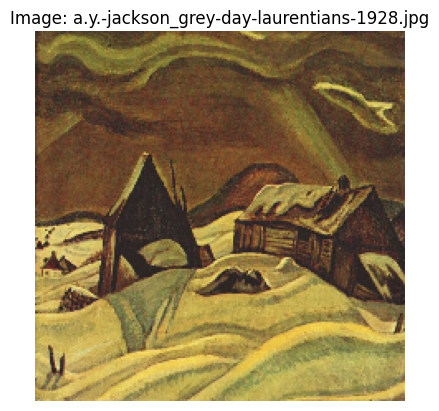

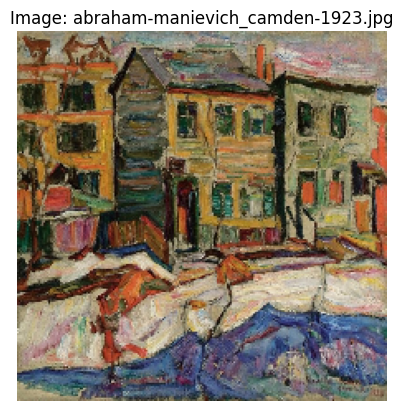

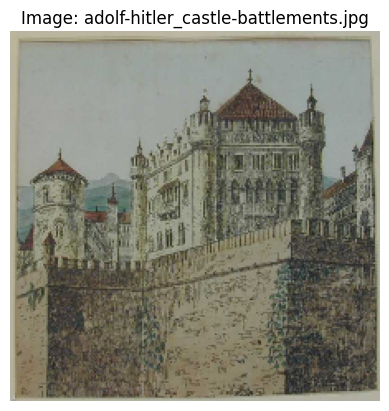

In [77]:

for i in test_images[0:3]:
    img = load_img(os.path.join("./data_split/test/",i), target_size=(224, 224))
    # Display the image
    plt.imshow(img)
    plt.title(f"Image: {i}")
    plt.axis('off')  # Turn off axis labels
    plt.show()
